In [92]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference
from mne.channels import read_layout
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne import viz
%matplotlib inline

In [75]:
# The eeg data contains four event markers. We'll use these to explore the data.
event_id = dict(response=4096, target=8192, NonTarget_High=16384, NonTarget_Low=32768)

# This will determine the time window for the data that we care about
tmin, tmax = -0.1, 1.

# path to data (change this to whereever you saved your data)
myPath = 'C:/Users/saisri/Desktop/Final year project/dataset/A01T.gdf'

In [76]:
#data = os.listdir(myPath)
#dataPath = os.path.join(myPath, data[1])

# We use mne.read_raw_edf to read in the .bdf EEG files


#raw = mne.io.read_raw_gdf('C:/Users/saisri/Desktop/Final year project/dataset/A01T.gdf', preload=True,stim_channel='auto', verbose=False)
raw = mne.io.read_raw_gdf(myPath, preload=True, stim_channel='auto', verbose=False)
raw

c:\users\saisri\appdata\local\programs\python\python37\lib\site-packages\mne\io\edf\edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
<ipython-input-76-63e4a346287b>:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(myPath, preload=True, stim_channel='auto', verbose=False)


<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MB, data loaded>

In [77]:
raw.rename_channels({'EEG-Fz':'Fz', 'EEG-0':'FC3', 'EEG-1':'FC1', 'EEG-2':'FCz', 'EEG-3':'FC2', 'EEG-4':'FC4', 'EEG-5':'C5', 'EEG-C3':'C3', 'EEG-6':'C1', 'EEG-Cz':'Cz', 'EEG-7':'C2', 'EEG-C4':'C4', 'EEG-8':'C6', 'EEG-9':'CP3', 'EEG-10':'CP1', 'EEG-11':'CPz', 'EEG-12':'CP2', 'EEG-13':'CP4', 'EEG-14':'P1', 'EEG-Pz':'Pz', 'EEG-15':'P2', 'EEG-16':'POz', 'EOG-left':'M1', 'EOG-central':'FPz', 'EOG-right':'M2'})

<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MB, data loaded>

In [78]:
print('Data type: {}\n\n{}\n'.format(type(raw), raw))
# print('{} \n'.format(raw))

# Get the sample rate
print('Sample rate:', raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(raw.get_data().shape))

# We can use the mne.info class to learn moure about the data.
print(raw.info)

Data type: <class 'mne.io.edf.edf.RawGDF'>

<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MB, data loaded>

Sample rate: 250.0 Hz
Size of the matrix: (25, 672528)

<Info | 7 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 25 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
>


In [79]:
print('The actual data is just a matrix array!\n\n {}\n'.format(raw.get_data()))

The actual data is just a matrix array!

 [[-2.11425781e-05 -2.19238281e-05 -1.56250000e-05 ...  5.51757812e-06
   1.46484375e-06  1.36718750e-06]
 [-2.36816406e-05 -2.39257812e-05 -1.97265625e-05 ...  1.04980469e-05
   3.07617188e-06  3.51562500e-06]
 [-2.14843750e-05 -2.43164062e-05 -1.88476562e-05 ...  1.49414062e-05
   9.22851563e-06  7.86132812e-06]
 ...
 [ 3.17382813e-05  2.24609375e-05  3.36914062e-05 ...  6.34765625e-06
  -4.39453125e-06 -4.39453125e-06]
 [-1.36718750e-05 -1.31835937e-05 -8.30078125e-06 ... -3.71093750e-05
  -4.78515625e-05 -4.54101562e-05]
 [-4.39453125e-05 -4.05273437e-05 -3.85742188e-05 ...  1.66015625e-05
   1.26953125e-05  7.81250000e-06]]



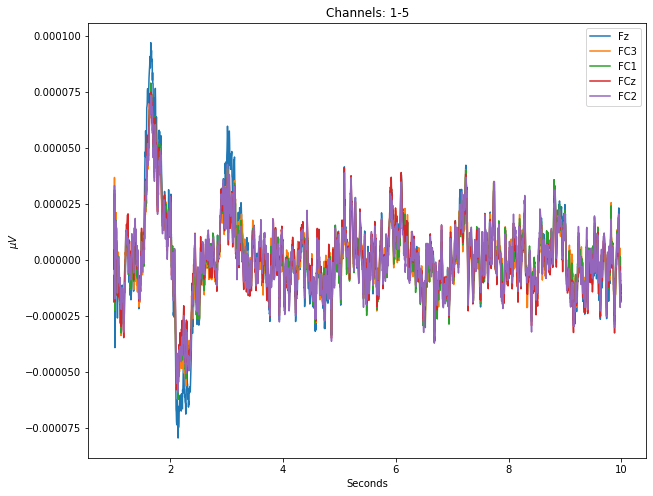

In [80]:
# Extract data from the first 5 channels, from 1 s to 3 s.

sfreq = raw.info['sfreq']
sfreq = raw.info['sfreq']
data, times = raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T);
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5');
plt.legend(raw.ch_names[:5]);

In [81]:
# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MB, data loaded>

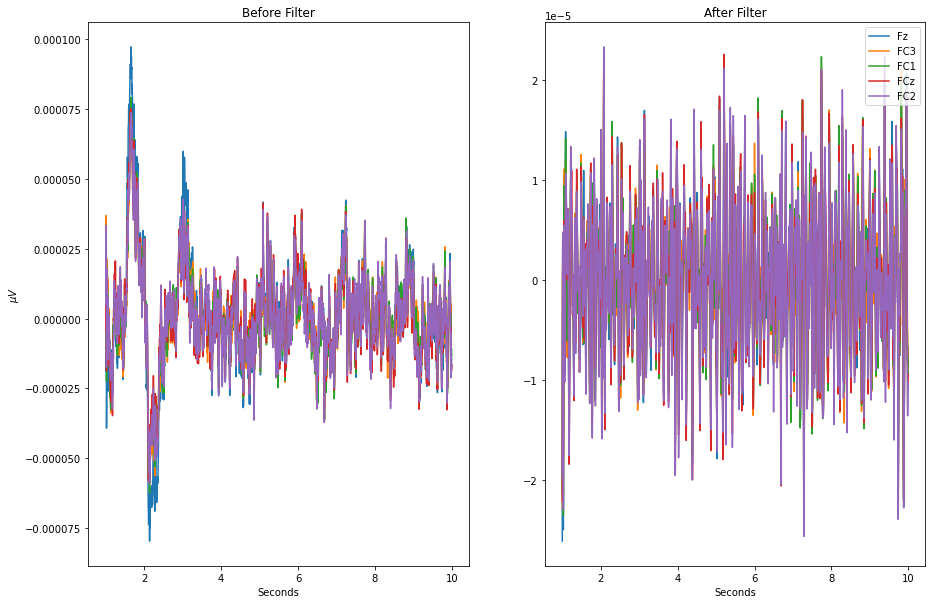

In [82]:
data_f, times_f = raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 10))

ax1.plot(times, data.T);
ax1.set_title('Before Filter')
ax1.set_xlabel('Seconds')
ax1.set_ylabel('$\mu V$')

ax2.plot(times_f, data_f.T);
ax2.set_title('After Filter')
ax2.set_xlabel('Seconds')

plt.legend(raw.ch_names[:5], loc=1);
# plt.tight_layout()

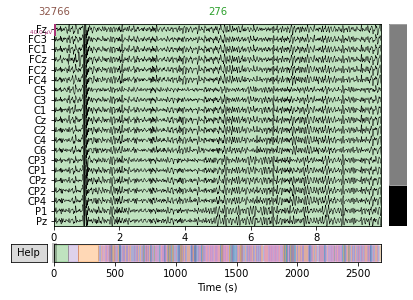

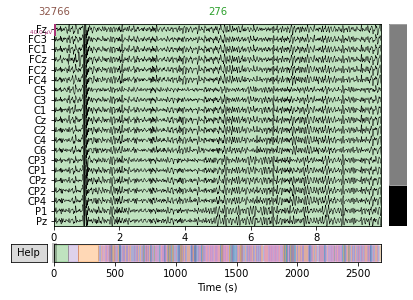

In [83]:
raw.plot()

In [84]:
#Converting time column to int64
raw_df = raw.to_data_frame()
raw_df.head()

,time,Fz,FC3,FC1,FCz,FC2,FC4,C5,C3,C1,...,CPz,CP2,CP4,P1,Pz,P2,POz,M1,FPz,M2
0,0,6.776264e-15,9.317362e-15,2.541099e-15,-8.470329e-16,8.470329e-16,6.776264e-15,1.694066e-15,8.470329e-16,8.470329e-16,...,0.000000,1.694066e-15,3.388132e-15,0.000000,1.016440e-14,8.470329e-15,5.082198e-15,-5.082198e-15,-1.524659e-14,-8.470329e-16
1,4,9.638018e-01,3.054357e-01,-1.447843e+00,-6.756032e-01,-8.442565e-01,2.487368e-01,-4.218371e-01,-6.332919e-01,-2.150721e+00,...,-1.077554,-1.556315e+00,-1.243891e+00,-2.032171,-1.546279e+00,-1.570067e+00,-1.421767e+00,2.648946e+00,6.698057e+00,7.058229e+00
2,8,2.521013e+00,1.546556e+00,-1.566182e+00,-1.400988e-01,-4.361846e-01,1.409487e+00,2.193679e-01,-1.264382e-01,-2.664136e+00,...,-1.040256,-1.825417e+00,-1.539976e+00,-2.559007,-1.858497e+00,-2.094397e+00,-1.432835e+00,4.430170e+00,1.195146e+01,1.155742e+01
3,12,4.727626e+00,4.003485e+00,1.456250e-01,2.029302e+00,1.668929e+00,3.782444e+00,2.368556e+00,1.949928e+00,-8.880560e-01,...,0.506293,-2.639897e-01,-4.636248e-01,-0.887311,-3.979605e-01,-1.080717e+00,6.391007e-01,4.830564e+00,1.486963e+01,1.226452e+01
4,16,6.894381e+00,7.012493e+00,2.994941e+00,5.137111e+00,4.750280e+00,6.772952e+00,5.547507e+00,4.989398e+00,2.411144e+00,...,2.925957,2.582213e+00,1.620200e+00,2.467362,2.346784e+00,1.125485e+00,4.342172e+00,3.863647e+00,1.536604e+01,9.856539e+00


In [85]:
ch_names=raw._raw_extras[0]['ch_names']

In [87]:
%matplotlib inline
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# events.shap|e
events = find_events(raw, shortest_event=0, stim_channel='STI 014', verbose=False)

epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True, verbose=False)

# remove channels that aren't eeg electrodes we care about
epochs.drop_channels(ch_names=['Nose', 'REOG', 'LEOG', 'IEOG', 'SEOG', 'M1', 'M2','EXG8'])

# Export data in tabular structure as a pandas DataFrame.
epochs_df = epochs.to_data_frame()


evoked = epochs['target'].average()
evoked.plot();

ValueError: No stim channel found to extract event triggers.

In [90]:
montage = mne.channels.make_standard_montage('biosemi64')
print(montage)

raw.set_montage(montage, set_dig=True)
raw_no_ref, _ = mne.set_eeg_reference(raw, [])
epochs_params = dict(events=events, event_id=event_id['target'], tmin=tmin, tmax=tmax)

evoked_no_ref = Epochs(raw_no_ref, **epochs_params).average()
evoked_no_ref.drop_channels(ch_names=['Nose', 'REOG', 'LEOG', 'IEOG', 'SEOG', 'M1', 'M2','EXG8'])

title = 'EEG Original reference'
evoked_no_ref.plot(titles=dict(eeg=title), time_unit='s')

evoked_no_ref.plot_topomap(times=[0.1], size=3., title=title, time_unit='s');

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 64 channels>


TypeError: set_montage() got an unexpected keyword argument 'set_dig'

In [93]:
average_eog = create_eog_epochs(raw).average()
print('We found %i EOG events' % average_eog.nave)
average_eog.plot_joint()

No EOG channels found
Trying with EEG 061 and EEG 062


RuntimeError: EEG 61 or EEG 62 channel not found !!